In [169]:
from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import umap
import json
from huggingface_hub import hf_hub_download
import pickle
from utils.load_cultural_dataset import CulturalBiasDataset
import os

In [170]:
def extract_distinct_native_concepts(dataset):
    """
    Extracts distinct native concepts with their embeddings, country, and native language.

    Args:
        cultural_bias_dataset: A CulturalBiasDataset object.
        country_to_language: A dictionary mapping countries to their native languages.

    Returns:
        A dictionary where keys are distinct native concepts and values are dictionaries
        containing 'embedding', 'country', and 'native_language'.
    """
    distinct_native_concepts = {}

    # Access the relevant columns directly from the dataset
    concept_native_list = dataset['concept_in_native']
    country_list = dataset['country']
    native_language_list = dataset['native_language']
    # Access th
    translated_concept_embeddings_list = dataset.embeddings['text_embeddings']['translated_concept_embedding']


    # Iterate through the extracted lists to build the distinct_native_concepts dictionary
    for i in range(len(concept_native_list)):
        concept_native = concept_native_list[i]
        country = country_list[i]
        native_language = native_language_list[i]

        # Ensure we have both concept_native and country before proceeding
        if concept_native is None or country is None:
            continue

        # Only add if the concept_native hasn't been added yet to ensure distinct concepts
        if concept_native not in distinct_native_concepts:
            embedding = translated_concept_embeddings_list[i]

            distinct_native_concepts[concept_native] = {'embedding': embedding, 'country': country, 'native_language': native_language}

    print(f"Found {len(distinct_native_concepts)} distinct native concepts with embeddings and country.")
    return distinct_native_concepts

In [171]:
def transform_embeddings_to_2d(distinct_native_concepts):
    """
    Transforms embeddings within the distinct_native_concepts dictionary by
    averaging higher-dimensional embeddings and reshaping all to (1, -1).

    Args:
        distinct_native_concepts: A dictionary where keys are concepts and values
                                  are dictionaries containing 'embedding'.

    Returns:
        The modified distinct_native_concepts dictionary with transformed embeddings.
    """
    # Iterate through the distinct_native_concepts dictionary
    for concept, data in distinct_native_concepts.items():
        embedding = data.get('embedding') # Use .get for safer access

        if embedding is None:
            print(f"Warning: No embedding found for concept '{concept}'. Skipping transformation.")
            continue

        # Ensure the embedding is a NumPy array before processing
        if not isinstance(embedding, np.ndarray):
            print(f"Warning: Embedding for concept '{concept}' is not a NumPy array ({type(embedding)}). Attempting to convert.")
            try:
                embedding = np.array(embedding).squeeze() # Convert and squeeze
            except Exception as e:
                print(f"Error converting embedding for '{concept}' to NumPy array: {e}. Skipping.")
                continue # Skip if conversion fails

        # Now process based on the number of dimensions
        if embedding.ndim >= 3:
            # Calculate the mean along dimensions 1 and 2 (averaging the middle dimensions)
            averaged_embedding = np.mean(embedding, axis=1)

            # Update the embedding in the dictionary
            distinct_native_concepts[concept]['embedding'] = averaged_embedding

        else:
            print(f"Warning: Embedding for '{concept}' has unexpected shape after squeezing: {embedding.shape}. Skipping transformation.")

    
    
    return distinct_native_concepts



In [172]:
def compute_umap_embeddings_from_native_concepts(distinct_native_concepts, cultural_bias_dataset, model_type, n_neighbors=15, min_dist=0.1, random_state=42):
    """
    Prepare translated concept and image embeddings, and compute their UMAP projections.

    Args:
        distinct_native_concepts (dict): Dictionary of native concepts with embeddings, country, and native_language.
        cultural_bias_dataset (CulturalBiasDataset): Loaded dataset with embeddings.
        n_neighbors (int): UMAP n_neighbors parameter.
        min_dist (float): UMAP min_dist parameter.
        random_state (int): UMAP random_state parameter.

    Returns:
        tuple: (
            translated_concept_embeddings (np.ndarray),
            translated_concept_language_labels (list),
            translated_concept_country_labels (list),
            translated_concept_labels (list),
            umap_translated_concept_embeddings (np.ndarray),
            image_embeddings (np.ndarray),
            image_country_labels (list),
            umap_image_embeddings (np.ndarray)
        )
    """
    if model_type in ["colqwen2.5", "colqwen2", "colpali"]:
        distinct_native_concepts = transform_embeddings_to_2d(distinct_native_concepts)

    # Prepare translated concept embeddings and labels
    translated_concept_embeddings_list = [item['embedding'].squeeze() for item in distinct_native_concepts.values()]
    translated_concept_language_labels = [item['native_language'] for item in distinct_native_concepts.values()]
    translated_concept_country_labels = [item['country'] for item in distinct_native_concepts.values()]
    translated_concept_labels = list(distinct_native_concepts.keys())
    translated_concept_embeddings = np.array(translated_concept_embeddings_list)

    print(f"Shape of translated_concept_embeddings: {translated_concept_embeddings.shape}")
    print(f"Number of language_labels: {len(translated_concept_language_labels)}")
    print(f"Number of country_labels: {len(translated_concept_country_labels)}")
    print(f"Number of concept_labels: {len(translated_concept_labels)}")

    # Prepare image embeddings and labels
    if model_type in ["colqwen2.5", "colqwen2", "colpali"]:
        image_embeddings = [np.mean(emb, axis=1) for emb in cultural_bias_dataset.embeddings['image_embedding']]
        image_embeddings =  np.array(image_embeddings).squeeze(1)
    else:
        image_embeddings =  np.array(cultural_bias_dataset.embeddings['image_embedding']).squeeze(1)
    
    image_country_labels = cultural_bias_dataset.embeddings['country']

    # UMAP projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    umap_translated_concept_embeddings = umap_reducer.fit_transform(translated_concept_embeddings)
    umap_image_embeddings = umap_reducer.fit_transform(image_embeddings)

    print(f"Shape of UMAP embeddings: {umap_translated_concept_embeddings.shape}")

    return (
        translated_concept_embeddings,
        translated_concept_language_labels,
        translated_concept_country_labels,
        translated_concept_labels,
        umap_translated_concept_embeddings,
        image_embeddings,
        image_country_labels,
        umap_image_embeddings
    )

In [231]:
def plot_umap_embeddings(model_name, umap_translated_concept_embeddings, umap_image_embeddings, translated_concept_language_labels, translated_concept_labels, image_country_labels, image_concept_labels):
    """
    Generates scatter plots of UMAP embeddings for translated concepts (colored by language) and images (colored by country).

    Args:
        umap_translated_concept_embeddings: numpy array or list of UMAP embeddings for translated concepts.
        umap_image_embeddings: numpy array or list of UMAP embeddings for images.
        translated_concept_language_labels: list or pandas Series of language labels for translated concepts.
        translated_concept_labels: list or pandas Series of concept labels for translated concepts.
        image_country_labels: list or pandas Series of country labels for images.
        image_concept_labels: list or pandas Series of concept labels for images.
    """
    # Step 3: Create DataFrames
    umap_translated_df = pd.DataFrame(umap_translated_concept_embeddings, columns=['UMAP_1', 'UMAP_2'])
    umap_translated_df['language'] = translated_concept_language_labels
    umap_translated_df['concept'] = translated_concept_labels # Add concept labels for potential hover information

    umap_image_df = pd.DataFrame(umap_image_embeddings, columns=['UMAP_1', 'UMAP_2'])
    umap_image_df['country'] = image_country_labels
    umap_image_df['concept'] = image_concept_labels

    # Sort dataframes using resource order
    umap_translated_df['language'] = pd.Categorical(umap_translated_df['language'], categories=sorted_language_by_resource, ordered=True)
    umap_translated_df = umap_translated_df.sort_values(by='language')
    umap_image_df['country'] = pd.Categorical(umap_image_df['country'], categories=sorted_country_by_resource, ordered=True)
    umap_image_df = umap_image_df.sort_values(by='country')


    # Step 4: Visualize Results using subplots
    fig, axes = plt.subplots(1, 2, figsize=(32, 12)) # Create a figure with 2 subplots

    # Add a main title to the figure
    fig.suptitle(f'UMAP Projection of Translated Concepts and Images for Model: {model_name}', fontsize=40, fontweight='bold')


    # Plot for Translated Concept Embeddings
    sns.scatterplot(
        x='UMAP_1',
        y='UMAP_2',
        hue='language',
        data=umap_translated_df,
        s=60,  # size of points - increased from 10
        alpha=0.7, # transparency of points
        palette=custom_language_colors, # Use custom color palette
        hue_order=sorted_language_by_resource,  # Use sorted order for languages
        ax=axes[0] # Specify the subplot axis
    )
    axes[0].set_title('UMAP Projection of Native Concept Embeddings by Language', fontsize=24, fontweight='bold')
    axes[0].set_xlabel('UMAP_1', fontsize=20)
    axes[0].set_ylabel('UMAP_2', fontsize=20)
    axes[0].legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18, markerscale=2)
    axes[0].tick_params(axis='both', which='major', labelsize=16)
    axes[0].grid(True)

    # Plot for Image Embeddings
    sns.scatterplot(
        x='UMAP_1',
        y='UMAP_2',
        hue='country',
        data=umap_image_df,
        s=60,  # size of points - increased from 10
        alpha=0.7, # transparency of points
        palette=custom_country_colors, # Use custom color palette
        hue_order=sorted_country_by_resource,  # Use sorted order for countries
        ax=axes[1] # Specify the subplot axis
    )
    axes[1].set_title(f'UMAP Projection of Image Embeddings by Country', fontsize=24, fontweight='bold')
    axes[1].set_xlabel('UMAP_1', fontsize=20)
    axes[1].set_ylabel('UMAP_2', fontsize=20)
    axes[1].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18, markerscale=2)
    axes[1].tick_params(axis='both', which='major', labelsize=16)
    axes[1].grid(True)


    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()

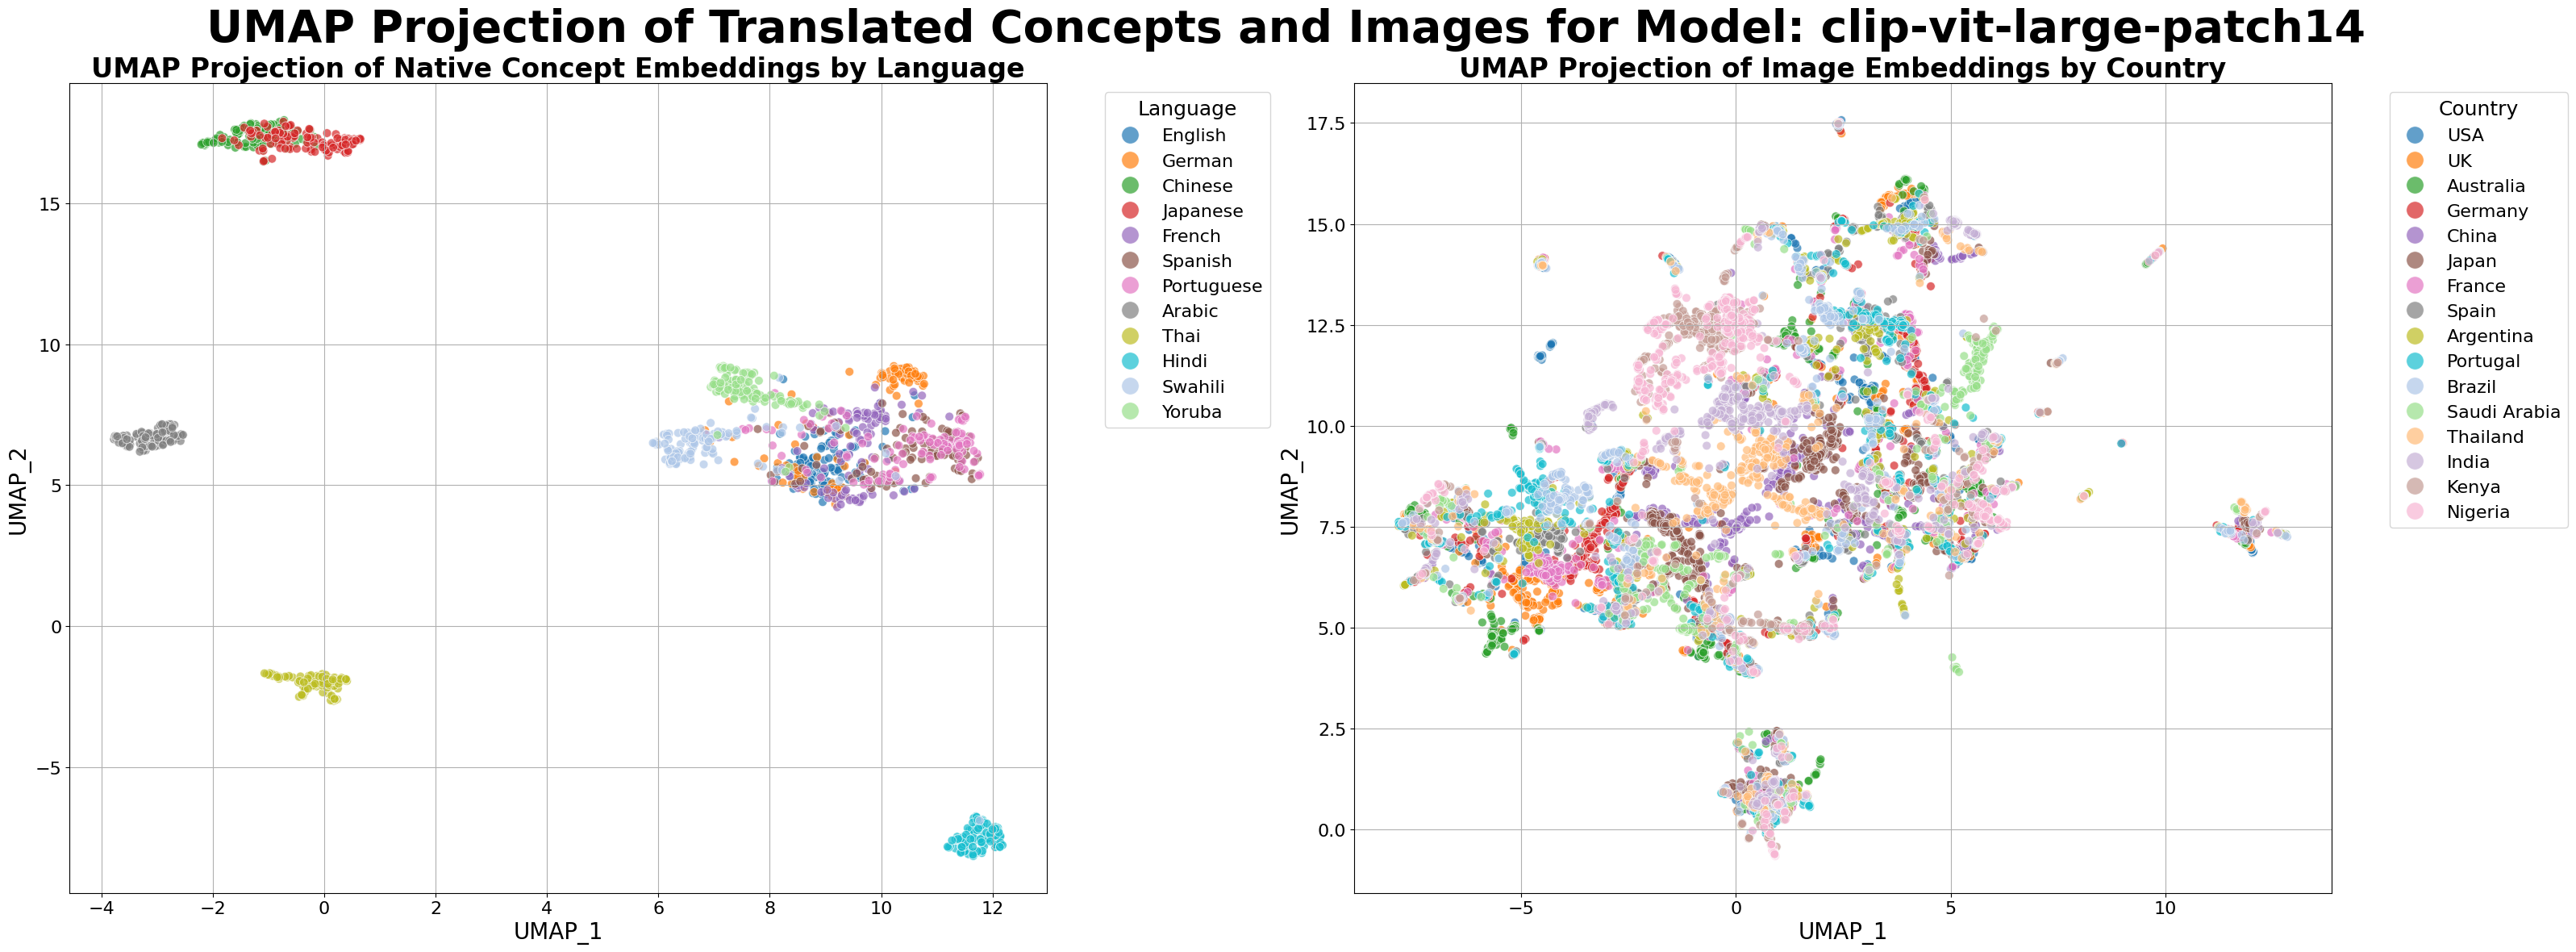

In [232]:
# Plot UMAP embeddings for translated concepts and images
plot_umap_embeddings(
    MODEL_NAME,
    umap_translated_concept_embeddings,
    umap_image_embeddings,
    translated_concept_language_labels,  # Changed to use language labels for consistency
    translated_concept_labels,
    image_country_labels,
    dataset['concept']  # image_concept_labels
)

In [175]:
# # Assuming umap_translated_concept_embeddings, umap_image_embeddings, language_labels, and concept_labels are already created in previous steps
# # Need to get image_country_labels and image_concept_labels from the dataset directly
# image_country_labels = dataset['country']
# image_concept_labels = dataset['concept']
# model_name = "fine-tuned gme-Qwen2-VL-7B"
# plot_umap_embeddings(model_name, umap_translated_concept_embeddings, umap_image_embeddings, translated_concept_language_labels, translated_concept_labels, image_country_labels, image_concept_labels)

In [221]:
from sklearn.metrics import silhouette_score, silhouette_samples
import pandas as pd
import numpy as np

def find_silhouette_score(embeddings, country_labels, embedding_type, country_to_language, remove_outliers=True, outlier_factor=1.5):
    """
    Calculates overall silhouette score, average distance to centroid, and silhouette scores per country for embeddings.
    Optionally removes outliers before calculation.

    Args:
        embeddings: numpy array of embeddings.
        country_labels: list or pandas Series of country labels corresponding to the embeddings.
        embedding_type: string indicating the type of embeddings (e.g., "Translated Concepts", "Images").
        country_to_language: A dictionary mapping countries to their native languages.
        remove_outliers: bool, whether to remove outliers before silhouette calculation (default: True).
        outlier_factor: float, IQR multiplier for outlier detection (default: 1.5).

    Returns:
        A tuple containing:
            overall_silhouette_score: The overall silhouette score.
            centroid_distances: A dictionary of average distances to centroid per country.
            country_silhouette_scores: A dictionary of silhouette scores per country.
    """
    print(f"--- Analysis for {embedding_type} ---")
    
    # Validate inputs
    if len(embeddings) != len(country_labels):
        raise ValueError(f"Mismatch: {len(embeddings)} embeddings vs {len(country_labels)} labels")
    
    # Convert to numpy arrays for consistency
    embeddings = np.array(embeddings)
    country_labels = np.array(country_labels)
    
    print(f"Original dataset size: {len(embeddings)} samples")
    
    # Remove outliers if requested
    if remove_outliers:
        print("Removing outliers using IQR method...")
        
        # Calculate distances from overall centroid for outlier detection
        overall_centroid = np.mean(embeddings, axis=0)
        distances_to_centroid = np.linalg.norm(embeddings - overall_centroid, axis=1)
        
        # Calculate IQR for outlier detection
        Q1 = np.percentile(distances_to_centroid, 25)
        Q3 = np.percentile(distances_to_centroid, 75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - outlier_factor * IQR
        upper_bound = Q3 + outlier_factor * IQR
        
        # Identify outliers
        outlier_mask = (distances_to_centroid >= lower_bound) & (distances_to_centroid <= upper_bound)
        
        # Remove outliers
        embeddings = embeddings[outlier_mask]
        country_labels = country_labels[outlier_mask]
        
        outliers_removed = np.sum(~outlier_mask)
        print(f"Removed {outliers_removed} outliers ({outliers_removed/len(outlier_mask)*100:.1f}%)")
        print(f"Final dataset size: {len(embeddings)} samples")
        print(f"Distance bounds: [{lower_bound:.3f}, {upper_bound:.3f}]")
        print()
    
    # Get unique countries and their counts
    unique_countries, counts = np.unique(country_labels, return_counts=True)
    print(f"Countries: {dict(zip(unique_countries, counts))}")
    
    # Check if we have enough data for silhouette analysis
    if len(unique_countries) < 2:
        print("ERROR: Need at least 2 different countries for silhouette analysis")
        return None, {}, {}
    
    # Calculate overall silhouette score
    overall_silhouette_score = None
    try:
        overall_silhouette_score = silhouette_score(embeddings, country_labels)
        print(f"Overall Silhouette Score: {overall_silhouette_score:.4f}")
    except Exception as e:
        print(f"Could not calculate overall silhouette score: {e}")
        return None, {}, {}

    # Calculate per-sample silhouette scores
    try:
        sample_silhouette_values = silhouette_samples(embeddings, country_labels)
    except Exception as e:
        print(f"Could not calculate per-sample silhouette scores: {e}")
        return overall_silhouette_score, {}, {}

    # Calculate centroid distances and per-country silhouette scores
    centroid_distances = {}
    country_silhouette_scores = {}
    
    for country in unique_countries:
        # Get indices for this country
        country_mask = (country_labels == country)
        country_embeddings = embeddings[country_mask]
        country_silhouette_samples = sample_silhouette_values[country_mask]
        
        # Calculate centroid distance
        if len(country_embeddings) > 0:
            centroid = np.mean(country_embeddings, axis=0)
            distances = np.linalg.norm(country_embeddings - centroid, axis=1)
            centroid_distances[country] = np.mean(distances)
        else:
            centroid_distances[country] = None
        
        # Calculate average silhouette score for this country
        if len(country_silhouette_samples) > 0:
            country_silhouette_scores[country] = np.mean(country_silhouette_samples)
        else:
            country_silhouette_scores[country] = None

    # Print results
    print("\nAverage distance to country centroid (within-country compactness):")
    sorted_centroid_distances = sorted(
        [(k, v) for k, v in centroid_distances.items() if v is not None], 
        key=lambda x: x[1]
    )
    for country, avg_distance in sorted_centroid_distances:
        print(f"{country}: {avg_distance:.4f}")

    print("\nSilhouette Score per Country:")
    sorted_country_silhouette_scores = sorted(
        [(k, v) for k, v in country_silhouette_scores.items() if v is not None], 
        key=lambda x: x[1], 
        reverse=True
    )
    for country, silhouette in sorted_country_silhouette_scores:
        print(f"{country}: {silhouette:.4f}")

    # Handle countries with insufficient data
    insufficient_data = [k for k, v in country_silhouette_scores.items() if v is None]
    if insufficient_data:
        print(f"\nCountries with insufficient data: {insufficient_data}")

    print("-" * 50)
    return overall_silhouette_score, centroid_distances, country_silhouette_scores

In [177]:
def sum_silhouette_across_modal(translated_concept_country_silhouette_scores, image_country_silhouette_scores, translated_concept_centroid_distances, image_centroid_distances, country_to_language):
    """
    Calculates the summed silhouette scores and average centroid distances per country.

    Args:
        translated_concept_country_silhouette_scores: A dictionary with native languages as keys and silhouette scores as values for translated concepts.
        image_country_silhouette_scores: A dictionary with native languages as keys and silhouette scores as values for images.
        translated_concept_centroid_distances: A dictionary with native languages as keys and average distances to centroid as values for translated concepts.
        image_centroid_distances: A dictionary with native languages as keys and average distances to centroid as values for images.
        country_to_language: A dictionary mapping countries to their native languages.

    Returns:
        A tuple containing:
            country_summed_silhouette_scores: A dictionary of summed silhouette scores per country.
            country_summed_centroid_distances: A dictionary of summed average centroid distances per country.
    """
    country_summed_silhouette_scores = {}
    country_summed_centroid_distances = {}

    all_countries = country_to_language.keys()

    for country in all_countries:
        language = country_to_language[country]
        # Sum silhouette scores
        if language in translated_concept_country_silhouette_scores:
            country_summed_silhouette_scores[country] = translated_concept_country_silhouette_scores[language]
        if country in image_country_silhouette_scores:
            country_summed_silhouette_scores[country] = country_summed_silhouette_scores.get(country, 0) + image_country_silhouette_scores[country]

        # Sum centroid distances
        if country in translated_concept_centroid_distances:
            country_summed_centroid_distances[country] = translated_concept_centroid_distances[country]
        if country in image_centroid_distances:
            country_summed_centroid_distances[country] = country_summed_centroid_distances.get(country, 0) + image_centroid_distances[country]

    return country_summed_silhouette_scores, country_summed_centroid_distances



In [178]:
# # Example usage (assuming variables are available from previous cells):
# country_summed_silhouette_scores, country_summed_centroid_distances = sum_silhouette_across_modal(
#     translated_concept_country_silhouette_scores,
#     image_country_silhouette_scores,
#     translated_concept_centroid_distances,
#     image_centroid_distances,
#     country_to_language
# )

## Generate report

### Load Evaluation Results

In [179]:
sorted_country_by_resource = ["USA", "UK", "Australia", "Germany", "China", "Japan", "France", "Spain", "Argentina", "Portugal", "Brazil", "Saudi Arabia","Thailand", "India",  "Kenya", "Nigeria" ]
sorted_language_by_resource = [
    "English",
    "German",
    "Chinese",
    "Japanese",
    "French",
    "Spanish",
    "Portuguese",
    "Arabic",
    "Thai",
    "Hindi",
    "Swahili",
    "Yoruba"
]

In [ ]:
model_rename = {
    ''
}

In [226]:
# Define custom color palettes based on the UMAP visualization
custom_language_colors = {
    "English": "#1f77b4",      # Blue
    "German": "#ff7f0e",       # Orange  
    "Chinese": "#2ca02c",      # Green
    "Japanese": "#d62728",     # Red
    "French": "#9467bd",       # Purple
    "Spanish": "#8c564b",      # Brown
    "Portuguese": "#e377c2",   # Pink
    "Arabic": "#7f7f7f",       # Gray
    "Thai": "#bcbd22",         # Olive
    "Hindi": "#17becf",        # Cyan
    "Swahili": "#aec7e8",      # Light blue
    "Yoruba": "#98df8a"        # Light green
}

custom_country_colors = {
    "USA": "#1f77b4",          # Blue
    "UK": "#ff7f0e",           # Orange
    "Australia": "#2ca02c",    # Green  
    "Germany": "#d62728",      # Red
    "China": "#9467bd",        # Purple
    "Japan": "#8c564b",        # Brown
    "France": "#e377c2",       # Pink
    "Spain": "#7f7f7f",        # Gray
    "Argentina": "#bcbd22",    # Olive
    "Portugal": "#17becf",     # Cyan
    "Brazil": "#aec7e8",       # Light blue
    "Saudi Arabia": "#98df8a", # Light green
    "Thailand": "#ffbb78",     # Light orange
    "India": "#c5b0d5",        # Light purple
    "Kenya": "#c49c94",        # Light brown
    "Nigeria": "#f7b6d3"       # Light pink
}

In [227]:
def plot_combined_analysis_with_images(model_name, country_df, translated_concept_country_silhouette_scores, image_country_silhouette_scores, country_summed_silhouette_scores, umap_translated_concept_embeddings, umap_image_embeddings, translated_concept_language_labels, translated_concept_country_labels, translated_concept_labels, image_country_labels, image_concept_labels):
    """
    Generates a figure with subplots comparing metrics and UMAP embeddings ordered by sorted_country_by_resource
    """
    # --- Prepare Data ---

    # Silhouette scores DataFrame for translated concepts
    translated_silhouette_df = pd.DataFrame.from_dict(translated_concept_country_silhouette_scores, orient='index', columns=['silhouette_score'])
    translated_silhouette_df.index.name = 'native_language'
    translated_silhouette_df = translated_silhouette_df.reset_index()
    translated_silhouette_df['embedding_type'] = 'Translated Concepts'

    # Silhouette scores DataFrame for images
    image_silhouette_df = pd.DataFrame.from_dict(image_country_silhouette_scores, orient='index', columns=['silhouette_score'])
    image_silhouette_df.index.name = 'country'
    image_silhouette_df = image_silhouette_df.reset_index()
    image_silhouette_df['embedding_type'] = 'Images'

    # Benchmark A_wins percentage (Text-to-Image)
    benchmark_country_df = country_df[(country_df['experiment'] == 'text-to-image') & (country_df['model'] == model_name)].copy()
    print(benchmark_country_df.head())
    if 'Total_wins' not in benchmark_country_df.columns or 'A_wins_percentage' not in benchmark_country_df.columns:
        benchmark_country_df['Total_wins'] = benchmark_country_df['A_wins'] + benchmark_country_df['B_wins'] + benchmark_country_df['C_wins']
        benchmark_country_df['A_wins_percentage'] = (benchmark_country_df['A_wins'] / benchmark_country_df['Total_wins']) * 100

    # Group the benchmark data by country and calculate the mean A_wins_percentage
    benchmark_grouped = benchmark_country_df.groupby('country')['A_wins_percentage'].mean().reset_index()
    benchmark_grouped = benchmark_grouped.rename(columns={'A_wins_percentage': 'mean_A_wins_percentage'})

    # Summed metrics DataFrames
    silhouette_summed_df = pd.DataFrame.from_dict(country_summed_silhouette_scores, orient='index', columns=['summed_silhouette_score'])
    silhouette_summed_df.index.name = 'country'
    silhouette_summed_df = silhouette_summed_df.reset_index()

    # UMAP DataFrames - Use country labels for translated concepts scatter plot
    umap_translated_df = pd.DataFrame(umap_translated_concept_embeddings, columns=['UMAP_1', 'UMAP_2'])
    umap_translated_df['country'] = translated_concept_country_labels  # Use country labels instead of language labels
    umap_translated_df['language'] = translated_concept_language_labels  # Add language labels for coloring
    umap_translated_df['concept'] = translated_concept_labels

    umap_image_df = pd.DataFrame(umap_image_embeddings, columns=['UMAP_1', 'UMAP_2'])
    umap_image_df['country'] = image_country_labels
    umap_image_df['concept'] = image_concept_labels

    # Sort UMAP dataframes by country
    umap_translated_df = umap_translated_df.sort_values(by='country')
    umap_image_df = umap_image_df.sort_values(by='country')

    # --- Plotting ---
    fig, axes = plt.subplots(3, 2, figsize=(28, 28))
    fig.suptitle(f'Combined Analysis for Model: {model_name}', fontsize=30, y=1.02)
    axes = axes.flatten()

    # Font size for all plot elements
    fontsize = 16
    title_fontsize = 20
    label_fontsize = 18
    tick_fontsize = 14
    legend_fontsize = 18
    bar_label_fontsize = 12

    # Use consistent tab20 palette for all plots to match UMAP embeddings
    # This ensures color consistency across all visualizations

    # Plot 1: Benchmark A_wins Percentage
    sns.barplot(x='country', y='mean_A_wins_percentage', data=benchmark_grouped, ax=axes[0], 
                palette=custom_country_colors, order=sorted_country_by_resource)
    axes[0].set_title('Benchmark A_wins Percentage (Text-to-Image)', fontsize=title_fontsize)
    axes[0].set_xlabel('Country', fontsize=label_fontsize)
    axes[0].set_ylabel('Mean A_wins Percentage', fontsize=label_fontsize)
    axes[0].tick_params(axis='x', rotation=90, labelsize=tick_fontsize)
    axes[0].tick_params(axis='y', labelsize=tick_fontsize)
    axes[0].grid(axis='y')
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.1f', label_type='edge', fontsize=bar_label_fontsize)

    # Plot 2: Summed Silhouette Scores
    sns.barplot(x='country', y='summed_silhouette_score', data=silhouette_summed_df, ax=axes[1], 
                palette=custom_country_colors, order=sorted_country_by_resource)
    axes[1].set_title('Sum of Silhouette Scores per Country', fontsize=title_fontsize)
    axes[1].set_xlabel('Country', fontsize=label_fontsize)
    axes[1].set_ylabel('Summed Silhouette Score', fontsize=label_fontsize)
    axes[1].tick_params(axis='x', rotation=90, labelsize=tick_fontsize)
    axes[1].tick_params(axis='y', labelsize=tick_fontsize)
    axes[1].grid(axis='y')
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.2f', label_type='edge', fontsize=bar_label_fontsize)

    # Plot 3: UMAP embeddings (Translated Concepts) - Now with language coloring and larger dots
    sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='language', data=umap_translated_df,
                    s=50, alpha=0.8, palette=custom_language_colors, ax=axes[2],
                    hue_order=sorted_language_by_resource)
    axes[2].set_title('UMAP Projection of Native Concept Embeddings by Language', fontsize=title_fontsize)
    axes[2].set_xlabel('UMAP_1', fontsize=label_fontsize)
    axes[2].set_ylabel('UMAP_2', fontsize=label_fontsize)
    legend2 = axes[2].legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', 
                            fontsize=legend_fontsize, title_fontsize=legend_fontsize, markerscale=3)
    axes[2].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[2].grid(True)

    # Plot 4: Silhouette Score (Translated Concepts)
    sns.barplot(x='native_language', y='silhouette_score', data=translated_silhouette_df,
                ax=axes[3], palette=custom_language_colors, order=sorted_language_by_resource)
    axes[3].set_title('Silhouette Score (Translated Concepts)', fontsize=title_fontsize)
    axes[3].set_xlabel('Native Language', fontsize=label_fontsize)
    axes[3].set_ylabel('Silhouette Score', fontsize=label_fontsize)
    axes[3].tick_params(axis='x', rotation=90, labelsize=tick_fontsize)
    axes[3].tick_params(axis='y', labelsize=tick_fontsize)
    axes[3].grid(axis='y')
    for container in axes[3].containers:
        axes[3].bar_label(container, fmt='%.2f', label_type='edge', fontsize=bar_label_fontsize)

    # Plot 5: UMAP embeddings (Images) with larger dots
    sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='country', data=umap_image_df,
                    s=50, alpha=0.8, palette=custom_country_colors, ax=axes[4],
                    hue_order=sorted_country_by_resource)
    axes[4].set_title('UMAP Projection of Image Embeddings by Country', fontsize=title_fontsize)
    axes[4].set_xlabel('UMAP_1', fontsize=label_fontsize)
    axes[4].set_ylabel('UMAP_2', fontsize=label_fontsize)
    legend4 = axes[4].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', 
                            fontsize=legend_fontsize, title_fontsize=legend_fontsize, markerscale=3)
    axes[4].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[4].grid(True)

    # Plot 6: Silhouette Score (Images)
    sns.barplot(x='country', y='silhouette_score', data=image_silhouette_df,
                ax=axes[5], palette=custom_country_colors, order=sorted_country_by_resource)
    axes[5].set_title('Silhouette Score (Images)', fontsize=title_fontsize)
    axes[5].set_xlabel('Country', fontsize=label_fontsize)
    axes[5].set_ylabel('Silhouette Score', fontsize=label_fontsize)
    axes[5].tick_params(axis='x', rotation=90, labelsize=tick_fontsize)
    axes[5].tick_params(axis='y', labelsize=tick_fontsize)
    axes[5].grid(axis='y')
    for container in axes[5].containers:
        axes[5].bar_label(container, fmt='%.2f', label_type='edge', fontsize=bar_label_fontsize)

    plt.tight_layout()
    plt.show()

## Main

In [ ]:
current_path = os.getcwd()
# BENCHMARK_PATH = os.path.join(current_path, 'benchmarks', 'cultural-bias-benchmark.pkl')
# DATASET_PATH = os.path.join(current_path, 'datasets', 'tierone003_deduplicated_and_renamed')

DATASET_PATH =  'Chula-AI/association_bias_benchmark'

EMBEDDING_DIR_PATH = os.path.join(current_path, 'embeddings')
EMBEDDING_FILE_NAME = 'image_text_embeddings_clip_vit_large_patch14_0_11759.pkl'

In [228]:
def find_model_type(model_name):
    """Determine model type from model name"""
    model_name = model_name.lower()
    if 'clip' in model_name:
        return 'clip'
    elif 'xlm' in model_name:
        return 'clip'
    elif 'jina' in model_name:
        return 'clip'
    elif 'siglip2' in model_name:
        return 'siglip2'
    elif 'gme' in model_name:
        return 'gme'
    elif 'colqwen2.5' in model_name:
        return 'colqwen2.5'
    elif 'colqwen2' in model_name:
        return 'colqwen2'
    elif 'colpali' in model_name:
        return 'colpali'
    else:
        raise ValueError(f"Unknown model type for model name: {model_name}")

In [229]:
MODEL_NAME = EMBEDDING_FILE_NAME[22:-12].replace('_', '-')
MODEL_TYPE = find_model_type(MODEL_NAME)

print(f"Evaluating model: {MODEL_NAME} of type {MODEL_TYPE}")

Evaluating model: clip-vit-large-patch14 of type clip


In [ ]:
# Evaluate a single embedding file and save summaries
dataset = CulturalBiasDataset(DATASET_PATH,EMBEDDING_DIR_PATH, EMBEDDING_FILE_NAME)
benchmark  = load_dataset(DATASET_PATH, name="benchmark", split='train')
# benchmark = pickle.load(open(BENCHMARK_PATH, 'rb'))


In [185]:
distinct_native_concepts = extract_distinct_native_concepts(dataset)

Found 1459 distinct native concepts with embeddings and country.


In [ ]:
(
    translated_concept_embeddings,
    translated_concept_language_labels,
    translated_concept_country_labels,
    translated_concept_labels,
    umap_translated_concept_embeddings,
    image_embeddings,
    image_country_labels,
    umap_image_embeddings
) = compute_umap_embeddings_from_native_concepts(
    distinct_native_concepts,
    dataset,
    model_type=MODEL_TYPE
)

In [187]:
country_to_language = dataset.country_to_language

In [188]:
# Calculate silhouette score for translated concept embeddings (cluster by LANGUAGE)
translated_concept_silhouette, translated_concept_centroid_distances, translated_concept_country_silhouette_scores = find_silhouette_score(
    translated_concept_embeddings,
    translated_concept_language_labels,  # Use language labels for clustering
    "Translated Concepts (by Language)",
    country_to_language,
    remove_outliers=False,  # Enable outlier removal
    outlier_factor=1.5     # IQR multiplier for outlier detection
)

# Calculate silhouette score for image embeddings (cluster by COUNTRY)
image_silhouette, image_centroid_distances, image_country_silhouette_scores = find_silhouette_score(
    image_embeddings,
    image_country_labels,  # Use country labels for clustering
    "Images (by Country)",
    country_to_language,
    remove_outliers=False,  # Enable outlier removal
    outlier_factor=1.5     # IQR multiplier for outlier detection
)

--- Analysis for Translated Concepts (by Language) ---
Original dataset size: 1459 samples
Countries: {np.str_('Arabic'): np.int64(116), np.str_('Chinese'): np.int64(123), np.str_('English'): np.int64(128), np.str_('French'): np.int64(113), np.str_('German'): np.int64(117), np.str_('Hindi'): np.int64(132), np.str_('Japanese'): np.int64(122), np.str_('Portuguese'): np.int64(127), np.str_('Spanish'): np.int64(117), np.str_('Swahili'): np.int64(120), np.str_('Thai'): np.int64(123), np.str_('Yoruba'): np.int64(121)}
Overall Silhouette Score: 0.0864

Average distance to country centroid (within-country compactness):
Chinese: 0.3276
Arabic: 0.3543
Thai: 0.3662
Hindi: 0.3686
Japanese: 0.4115
Yoruba: 0.4287
Swahili: 0.4852
English: 0.5264
German: 0.5334
Portuguese: 0.5486
Spanish: 0.5570
French: 0.5612

Silhouette Score per Country:
Arabic: 0.2508
Hindi: 0.2310
Thai: 0.2299
Chinese: 0.1635
Yoruba: 0.1339
English: 0.0508
Swahili: 0.0292
German: 0.0146
Portuguese: -0.0062
French: -0.0104
Spanish

In [189]:
# Validation: Check data consistency
print("=== VALIDATION CHECKS ===")
print(f"Translated concept embeddings shape: {translated_concept_embeddings.shape}")
print(f"Translated concept language labels length: {len(translated_concept_language_labels)}")
print(f"Unique languages: {set(translated_concept_language_labels)}")
print()
print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Image country labels length: {len(image_country_labels)}")
print(f"Unique countries in images: {set(image_country_labels)}")
print()
print(f"Country to language mapping: {country_to_language}")
print("=" * 50)

=== VALIDATION CHECKS ===
Translated concept embeddings shape: (1459, 768)
Translated concept language labels length: 1459
Unique languages: {'Japanese', 'Swahili', 'Chinese', 'Hindi', 'Arabic', 'German', 'Spanish', 'English', 'Yoruba', 'Portuguese', 'Thai', 'French'}

Image embeddings shape: (11759, 768)
Image country labels length: 11759
Unique countries in images: {'Spain', 'India', 'Kenya', 'China', 'Argentina', 'Nigeria', 'Australia', 'Portugal', 'Japan', 'Brazil', 'France', 'USA', 'Germany', 'Saudi Arabia', 'Thailand', 'UK'}

Country to language mapping: {'Argentina': 'Spanish', 'Australia': 'English', 'Brazil': 'Portuguese', 'China': 'Chinese', 'France': 'French', 'Germany': 'German', 'India': 'Hindi', 'Japan': 'Japanese', 'Kenya': 'Swahili', 'Nigeria': 'Yoruba', 'Portugal': 'Portuguese', 'Saudi Arabia': 'Arabic', 'Spain': 'Spanish', 'Thailand': 'Thai', 'UK': 'English', 'USA': 'English'}


In [190]:
# Example usage (assuming variables are available from previous cells):
country_summed_silhouette_scores, country_summed_centroid_distances = sum_silhouette_across_modal(
    translated_concept_country_silhouette_scores,
    image_country_silhouette_scores,
    translated_concept_centroid_distances,
    image_centroid_distances,
    country_to_language
)

In [191]:
AGGREGATED_RESULTS_PATH = os.path.join('evaluation_results', 'aggregated')
concept_df = pd.read_csv(os.path.join(AGGREGATED_RESULTS_PATH, 'concept_aggregated.csv'))
country_df = pd.read_csv(os.path.join(AGGREGATED_RESULTS_PATH, 'country_aggregated.csv'))
overall_df = pd.read_csv(os.path.join(AGGREGATED_RESULTS_PATH, 'overall_aggregated.csv'))
language_df = pd.read_csv(os.path.join(AGGREGATED_RESULTS_PATH, 'language_aggregated.csv'))

In [ ]:
# Plot combined analysis with images
try:
    plot_combined_analysis_with_images(
        MODEL_NAME,
        country_df,
        translated_concept_country_silhouette_scores,
        image_country_silhouette_scores,
        country_summed_silhouette_scores,
        umap_translated_concept_embeddings,
        umap_image_embeddings,
        translated_concept_language_labels,
        translated_concept_country_labels,
        translated_concept_labels,
        image_country_labels,
        dataset['concept']  # Assuming this is the image_concept_labels
    )
except NameError:
    print("country_df is not defined. Please load or create country_df with benchmark evaluation results before plotting.")

In [193]:
def compute_correlation_metrics(model_name, country_df, country_summed_silhouette_scores):
    """
    Computes correlation metrics between A_wins percentage and summed silhouette scores.
    
    Args:
        model_name: Name of the model to analyze
        country_df: DataFrame containing A_wins data per country
        country_summed_silhouette_scores: Dictionary of summed silhouette scores per country
    
    Returns:
        correlation metrics dictionary
    """
    # Filter data for the specific model and experiment type
    model_country_df = country_df[(country_df['model'] == model_name) & 
                                (country_df['experiment'] == 'text-to-image')].copy()
    
    # Calculate A_wins percentage
    model_country_df['A_wins_percentage'] = (model_country_df['A_wins'] / 
                                           (model_country_df['A_wins'] + model_country_df['B_wins'] + model_country_df['C_wins'])) * 100
    
    # Create lists for correlation analysis
    countries = []
    wins_percentages = []
    silhouette_scores = []
    
    # Collect data for countries that have both metrics
    for country in sorted_country_by_resource:
        if country in country_summed_silhouette_scores and country in model_country_df['country'].values:
            country_wins = model_country_df[model_country_df['country'] == country]['A_wins_percentage'].values[0]
            country_silhouette = country_summed_silhouette_scores[country]
            
            countries.append(country)
            wins_percentages.append(country_wins)
            silhouette_scores.append(country_silhouette)
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(wins_percentages, silhouette_scores)[0,1]
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Country': countries,
        'A_wins_percentage': wins_percentages,
        'Summed_Silhouette': silhouette_scores
    })
    
    # Sort by A_wins_percentage for better visualization
    comparison_df = comparison_df.sort_values('A_wins_percentage', ascending=False)
    
    # Calculate additional metrics
    metrics = {
        'correlation': correlation,
        'mean_wins_percentage': np.mean(wins_percentages),
        'mean_silhouette': np.mean(silhouette_scores),
        'wins_std': np.std(wins_percentages),
        'silhouette_std': np.std(silhouette_scores),
        'comparison_df': comparison_df
    }
    
    return metrics

In [194]:
compute_correlation_metrics(MODEL_NAME,  country_df, country_summed_silhouette_scores)

{'correlation': np.float64(-0.6871207949765213),
 'mean_wins_percentage': np.float64(51.23633915468335),
 'mean_silhouette': np.float32(0.090759866),
 'wins_std': np.float64(31.3375754148733),
 'silhouette_std': np.float32(0.106159106),
 'comparison_df':          Country  A_wins_percentage  Summed_Silhouette
 0            USA          95.730706           0.072289
 2      Australia          94.729542           0.081665
 1             UK          94.565217           0.065896
 7          Spain          78.002378          -0.001699
 6         France          75.526316           0.001227
 8      Argentina          69.649805          -0.013142
 9       Portugal          65.776699          -0.004371
 10        Brazil          61.325967           0.006541
 3        Germany          52.419355           0.028035
 5          Japan          31.071050          -0.014943
 14         Kenya          27.833333           0.047047
 4          China          25.171939           0.198447
 15       Nigeria 

In [195]:
def analyze_self_preference_and_silhouette_correlation(model_name, country_df, translated_concept_country_silhouette_scores, image_country_silhouette_scores, country_to_language):
    """
    Analyzes self-preference (B_wins/C_wins) and correlation between text and image silhouette scores.
    
    Args:
        model_name: Name of the model to analyze
        country_df: DataFrame containing benchmark results
        translated_concept_country_silhouette_scores: Dictionary of silhouette scores for text embeddings
        image_country_silhouette_scores: Dictionary of silhouette scores for image embeddings
        country_to_language: Dictionary mapping countries to languages
    """
    # Filter data for the specific model and experiment type
    model_country_df = country_df[(country_df['model'] == model_name) & 
                                (country_df['experiment'] == 'text-to-image')].copy()
    
    # Calculate self-preference ratio (B_wins/C_wins)
    model_country_df['self_preference_ratio'] = model_country_df['B_wins'] / model_country_df['A_wins']
    
    # Prepare lists for correlation analysis
    countries = []
    self_preference_ratios = []
    text_silhouette_scores = []
    image_silhouette_scores = []
    
    # Collect data for countries that have all metrics
    for country in sorted_country_by_resource:
        language = country_to_language.get(country)
        
        if (country in model_country_df['country'].values and 
            language in translated_concept_country_silhouette_scores and 
            country in image_country_silhouette_scores):
            
            country_ratio = model_country_df[model_country_df['country'] == country]['self_preference_ratio'].values[0]
            text_silhouette = translated_concept_country_silhouette_scores[language]
            image_silhouette = image_country_silhouette_scores[country]
            
            countries.append(country)
            self_preference_ratios.append(country_ratio)
            text_silhouette_scores.append(text_silhouette)
            image_silhouette_scores.append(image_silhouette)
    
    # Calculate correlations
    silhouette_correlation = np.corrcoef(text_silhouette_scores, image_silhouette_scores)[0,1]
    text_self_preference_correlation = np.corrcoef(text_silhouette_scores, self_preference_ratios)[0,1]
    image_self_preference_correlation = np.corrcoef(image_silhouette_scores, self_preference_ratios)[0,1]
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Country': countries,
        'Self_Preference_Ratio': self_preference_ratios,
        'Text_Silhouette': text_silhouette_scores,
        'Image_Silhouette': image_silhouette_scores
    })
    
    # Sort by self-preference ratio for better visualization
    comparison_df = comparison_df.sort_values('Self_Preference_Ratio', ascending=False)
    
    # Print results
    print(f"Analysis for model: {model_name}")
    print("\nCorrelations:")
    print(f"Text-Image Silhouette Correlation: {silhouette_correlation:.4f}")
    print(f"Text Silhouette - Self Preference Correlation: {text_self_preference_correlation:.4f}")
    print(f"Image Silhouette - Self Preference Correlation: {image_self_preference_correlation:.4f}")
    
    print("\nSelf-Preference Ratios by Country:")
    print(comparison_df[['Country', 'Self_Preference_Ratio']].to_string(index=False))
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot self-preference ratios
    sns.barplot(data=comparison_df, x='Country', y='Self_Preference_Ratio', ax=ax1)
    ax1.set_title('Self-Preference Ratio by Country')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Plot silhouette scores comparison
    comparison_df.plot(x='Country', y=['Text_Silhouette', 'Image_Silhouette'], kind='bar', ax=ax2)
    ax2.set_title('Text vs Image Silhouette Scores by Country')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.legend(['Text Silhouette', 'Image Silhouette'])
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

In [196]:
def plot_self_preference_vs_silhouette_scores(model_name, country_df, translated_concept_country_silhouette_scores, image_country_silhouette_scores, country_to_language):
    """
    Creates line graphs showing the relationship between Self-Preference Ratio and both Text & Image Silhouette scores for each country.
    
    Args:
        model_name: Name of the model to analyze
        country_df: DataFrame containing benchmark results
        translated_concept_country_silhouette_scores: Dictionary of silhouette scores for text embeddings
        image_country_silhouette_scores: Dictionary of silhouette scores for image embeddings
        country_to_language: Dictionary mapping countries to languages
    
    Returns:
        comparison_df: DataFrame with the data used for plotting
    """
    # Filter data for the specific model and experiment type
    model_country_df = country_df[(country_df['model'] == model_name) & 
                                (country_df['experiment'] == 'text-to-image')].copy()
    
    # Calculate self-preference ratio (B_wins/A_wins)
    model_country_df['self_preference_ratio'] = model_country_df['B_wins'] / model_country_df['A_wins']
    
    # Prepare lists for analysis
    countries = []
    self_preference_ratios = []
    text_silhouette_scores = []
    image_silhouette_scores = []
    
    # Collect data for countries that have all metrics (in resource order)
    for country in sorted_country_by_resource:
        language = country_to_language.get(country)
        
        if (country in model_country_df['country'].values and 
            language in translated_concept_country_silhouette_scores and
            country in image_country_silhouette_scores):
            
            country_ratio = model_country_df[model_country_df['country'] == country]['self_preference_ratio'].values[0]
            text_silhouette = translated_concept_country_silhouette_scores[language]
            image_silhouette = image_country_silhouette_scores[country]
            
            countries.append(country)
            self_preference_ratios.append(country_ratio)
            text_silhouette_scores.append(text_silhouette)
            image_silhouette_scores.append(image_silhouette)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Country': countries,
        'Self_Preference_Ratio': self_preference_ratios,
        'Text_Silhouette': text_silhouette_scores,
        'Image_Silhouette': image_silhouette_scores
    })
    
    # Countries are already in sorted_country_by_resource order from the loop above
    # Create resource order column for consistent ordering
    comparison_df['Resource_Order'] = range(len(comparison_df))
    
    # Calculate correlations
    text_correlation = np.corrcoef(self_preference_ratios, text_silhouette_scores)[0,1]
    image_correlation = np.corrcoef(self_preference_ratios, image_silhouette_scores)[0,1]
    
    # Create the visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 16))
    
    # Add main title to the entire figure
    fig.suptitle(f'Self-Preference Ratio vs Silhouette Scores Analysis for Model: CLIP-L/4', 
                 fontsize=50, y=0.98, fontweight='bold')
    
    # Plot 1: Line graph with Text Silhouette (dual y-axes)
    line_df = comparison_df.copy()
    
    # Primary axis - Self Preference Ratio
    color1 = 'blue'
    ax1.set_xlabel('Countries (ordered by resource availability)', fontsize=30)
    ax1.set_ylabel('Self-Preference Ratio', color=color1, fontsize=30)
    line1 = ax1.plot(line_df['Resource_Order'], line_df['Self_Preference_Ratio'], 
                     marker='o', linewidth=3, markersize=10, label='Self Preference Ratio', 
                     color=color1)
    ax1.tick_params(axis='y', labelcolor=color1, labelsize=30)
    ax1.set_xticks(line_df['Resource_Order'])
    ax1.set_xticklabels(line_df['Country'], rotation=45, ha='right', fontsize=30)
    ax1.grid(True, alpha=0.3)
    
    # Secondary axis - Text Silhouette
    color2 = 'red'
    ax1_twin = ax1.twinx()
    ax1_twin.set_ylabel('Text Silhouette Score', color=color2, fontsize=30)
    line2 = ax1_twin.plot(line_df['Resource_Order'], line_df['Text_Silhouette'], 
                          marker='s', linewidth=3, markersize=10, label='Text Silhouette', 
                          color=color2)
    ax1_twin.tick_params(axis='y', labelcolor=color2, labelsize=30)
    
    # Title and correlation info
    ax1.set_title(f'Self-Preference Ratio vs Text Silhouette by Country', 
                  fontsize=40, pad=20)
    
    # Add correlation text box
    ax1.text(0.05, 0.85, f'Correlation: {text_correlation:.3f}', 
             transform=ax1.transAxes, fontsize=30, 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=30)
    
    # Plot 2: Line graph with Image Silhouette (dual y-axes)
    # Primary axis - Self Preference Ratio (reuse)
    ax2.set_xlabel('Countries (ordered by resource availability)', fontsize=30)
    ax2.set_ylabel('Self-Preference Ratio', color=color1, fontsize=30)
    ax2.plot(line_df['Resource_Order'], line_df['Self_Preference_Ratio'], 
             marker='o', linewidth=3, markersize=10, label='Self Preference Ratio', 
             color=color1)
    ax2.tick_params(axis='y', labelcolor=color1, labelsize=30)
    ax2.set_xticks(line_df['Resource_Order'])
    ax2.set_xticklabels(line_df['Country'], rotation=45, ha='right', fontsize=30)
    ax2.grid(True, alpha=0.3)
    
    # Secondary axis - Image Silhouette
    color3 = 'green'
    ax2_twin = ax2.twinx()
    ax2_twin.set_ylabel('Image Silhouette Score', color=color3, fontsize=30)
    ax2_twin.plot(line_df['Resource_Order'], line_df['Image_Silhouette'], 
                  marker='^', linewidth=3, markersize=10, label='Image Silhouette', 
                  color=color3)
    ax2_twin.tick_params(axis='y', labelcolor=color3, labelsize=30)
    
    # Title and correlation info
    ax2.set_title(f'Self-Preference Ratio vs Image Silhouette by Country', 
                  fontsize=40, pad=20)
    
    # Add correlation text box
    ax2.text(0.05, 0.85, f'Correlation: {image_correlation:.3f}', 
             transform=ax2.transAxes, fontsize=30, 
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Add legends
    lines2_1, labels2_1 = ax2.get_legend_handles_labels()
    lines2_2, labels2_2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines2_1 + lines2_2, labels2_1 + labels2_2, loc='upper center', fontsize=30)
    
    # Plot 3: Scatter plot - Text Silhouette
    ax3.scatter(comparison_df['Text_Silhouette'], comparison_df['Self_Preference_Ratio'], 
                s=150, alpha=0.7, c='purple', edgecolors='black', linewidth=1)
    
    # Add country labels to scatter points
    for i, row in comparison_df.iterrows():
        if row['Country'] in ['Argentina', 'UK']:
            ax3.annotate(row['Country'], 
                     (row['Text_Silhouette'], row['Self_Preference_Ratio']),
                     xytext=(8, 8), textcoords='offset points', 
                     fontsize=20, alpha=0.8, ha='right')
        elif row['Country'] in ['Brazil', ]:
            ax3.annotate(row['Country'], 
                        (row['Text_Silhouette'], row['Self_Preference_Ratio']),
                        xytext=(8, 20), textcoords='offset points', 
                        fontsize=20, alpha=0.8, ha='right')
        elif row['Country'] in ['Spain', 'Saudi Arabia', "Thailand"]:
            ax3.annotate(row['Country'], 
                        (row['Text_Silhouette'], row['Self_Preference_Ratio']),
                        xytext=(8, -20), textcoords='offset points', 
                        fontsize=20, alpha=0.8, ha='right')
        elif row['Country'] in ['Spain', 'Portugal', 'USA', 'India']:
            ax3.annotate(row['Country'], 
                        (row['Text_Silhouette'], row['Self_Preference_Ratio']),
                        xytext=(8, -20), textcoords='offset points', 
                        fontsize=20, alpha=0.8, ha='left')
        else:
            ax3.annotate(row['Country'], 
                        (row['Text_Silhouette'], row['Self_Preference_Ratio']),
                        xytext=(8, 8), textcoords='offset points', 
                        fontsize=20, alpha=0.8, ha='left')
        
    # Add trend line
    z = np.polyfit(comparison_df['Text_Silhouette'], comparison_df['Self_Preference_Ratio'], 1)
    p = np.poly1d(z)
    trend_x = np.linspace(comparison_df['Text_Silhouette'].min(), comparison_df['Text_Silhouette'].max(), 100)
    ax3.plot(trend_x, p(trend_x), "r--", alpha=0.8, linewidth=2, label=f'Trend Line (r={text_correlation:.3f})')
    
    ax3.set_xlabel('Text Silhouette Score', fontsize=30)
    ax3.set_ylabel('Self-Preference Ratio', fontsize=30)
    ax3.set_title(f'Self-Preference vs Text Silhouette', 
                  fontsize=40, pad=20)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=30)
    ax3.tick_params(axis='both', which='major', labelsize=30)
    
    # Plot 4: Scatter plot - Image Silhouette
    ax4.scatter(comparison_df['Image_Silhouette'], comparison_df['Self_Preference_Ratio'], 
                s=150, alpha=0.7, c='orange', edgecolors='black', linewidth=1)
    
    # Add country labels to scatter points
    for i, row in comparison_df.iterrows():
        if row['Country'] in ['France', 'USA']:
            ax4.annotate(row['Country'], 
                        (row['Image_Silhouette'], row['Self_Preference_Ratio']),
                        xytext=(8, -20), textcoords='offset points', 
                        fontsize=20, alpha=0.8, ha='right')
        elif row['Country'] in ['Brazil', 'Portugal', 'Saudi Arabia']:
            ax4.annotate(row['Country'], 
                        (row['Image_Silhouette'], row['Self_Preference_Ratio']),
                        xytext=(8, 8), textcoords='offset points', 
                        fontsize=20, alpha=0.8, ha='right')
        elif row['Country'] in ['Spain', 'India']:
            ax4.annotate(row['Country'], 
                        (row['Image_Silhouette'], row['Self_Preference_Ratio']),
                        xytext=(8, -20), textcoords='offset points', 
                        fontsize=20, alpha=0.8, ha='left')
        else:
            ax4.annotate(row['Country'], 
                        (row['Image_Silhouette'], row['Self_Preference_Ratio']),
                        xytext=(8, 8), textcoords='offset points', 
                        fontsize=20, alpha=0.8, ha='left')
    
    # Add trend line
    z = np.polyfit(comparison_df['Image_Silhouette'], comparison_df['Self_Preference_Ratio'], 1)
    p = np.poly1d(z)
    trend_x = np.linspace(comparison_df['Image_Silhouette'].min(), comparison_df['Image_Silhouette'].max(), 100)
    ax4.plot(trend_x, p(trend_x), "g--", alpha=0.8, linewidth=2, label=f'Trend Line (r={image_correlation:.3f})')
    
    ax4.set_xlabel('Image Silhouette Score', fontsize=30)
    ax4.set_ylabel('Self-Preference Ratio', fontsize=30)
    ax4.set_title(f'Self-Preference vs Image Silhouette', 
                  fontsize=40, pad=20)
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=30, loc='upper left') 
    ax4.tick_params(axis='both', which='major', labelsize=30)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for model: {model_name}")
    print(f"Correlation between Self-Preference Ratio and Text Silhouette: {text_correlation:.4f}")
    print(f"Correlation between Self-Preference Ratio and Image Silhouette: {image_correlation:.4f}")
    print(f"Countries analyzed: {len(countries)}")
    print(f"Self-Preference Ratio range: {min(self_preference_ratios):.3f} - {max(self_preference_ratios):.3f}")
    print(f"Text Silhouette Score range: {min(text_silhouette_scores):.3f} - {max(text_silhouette_scores):.3f}")
    print(f"Image Silhouette Score range: {min(image_silhouette_scores):.3f} - {max(image_silhouette_scores):.3f}")
    
    return comparison_df

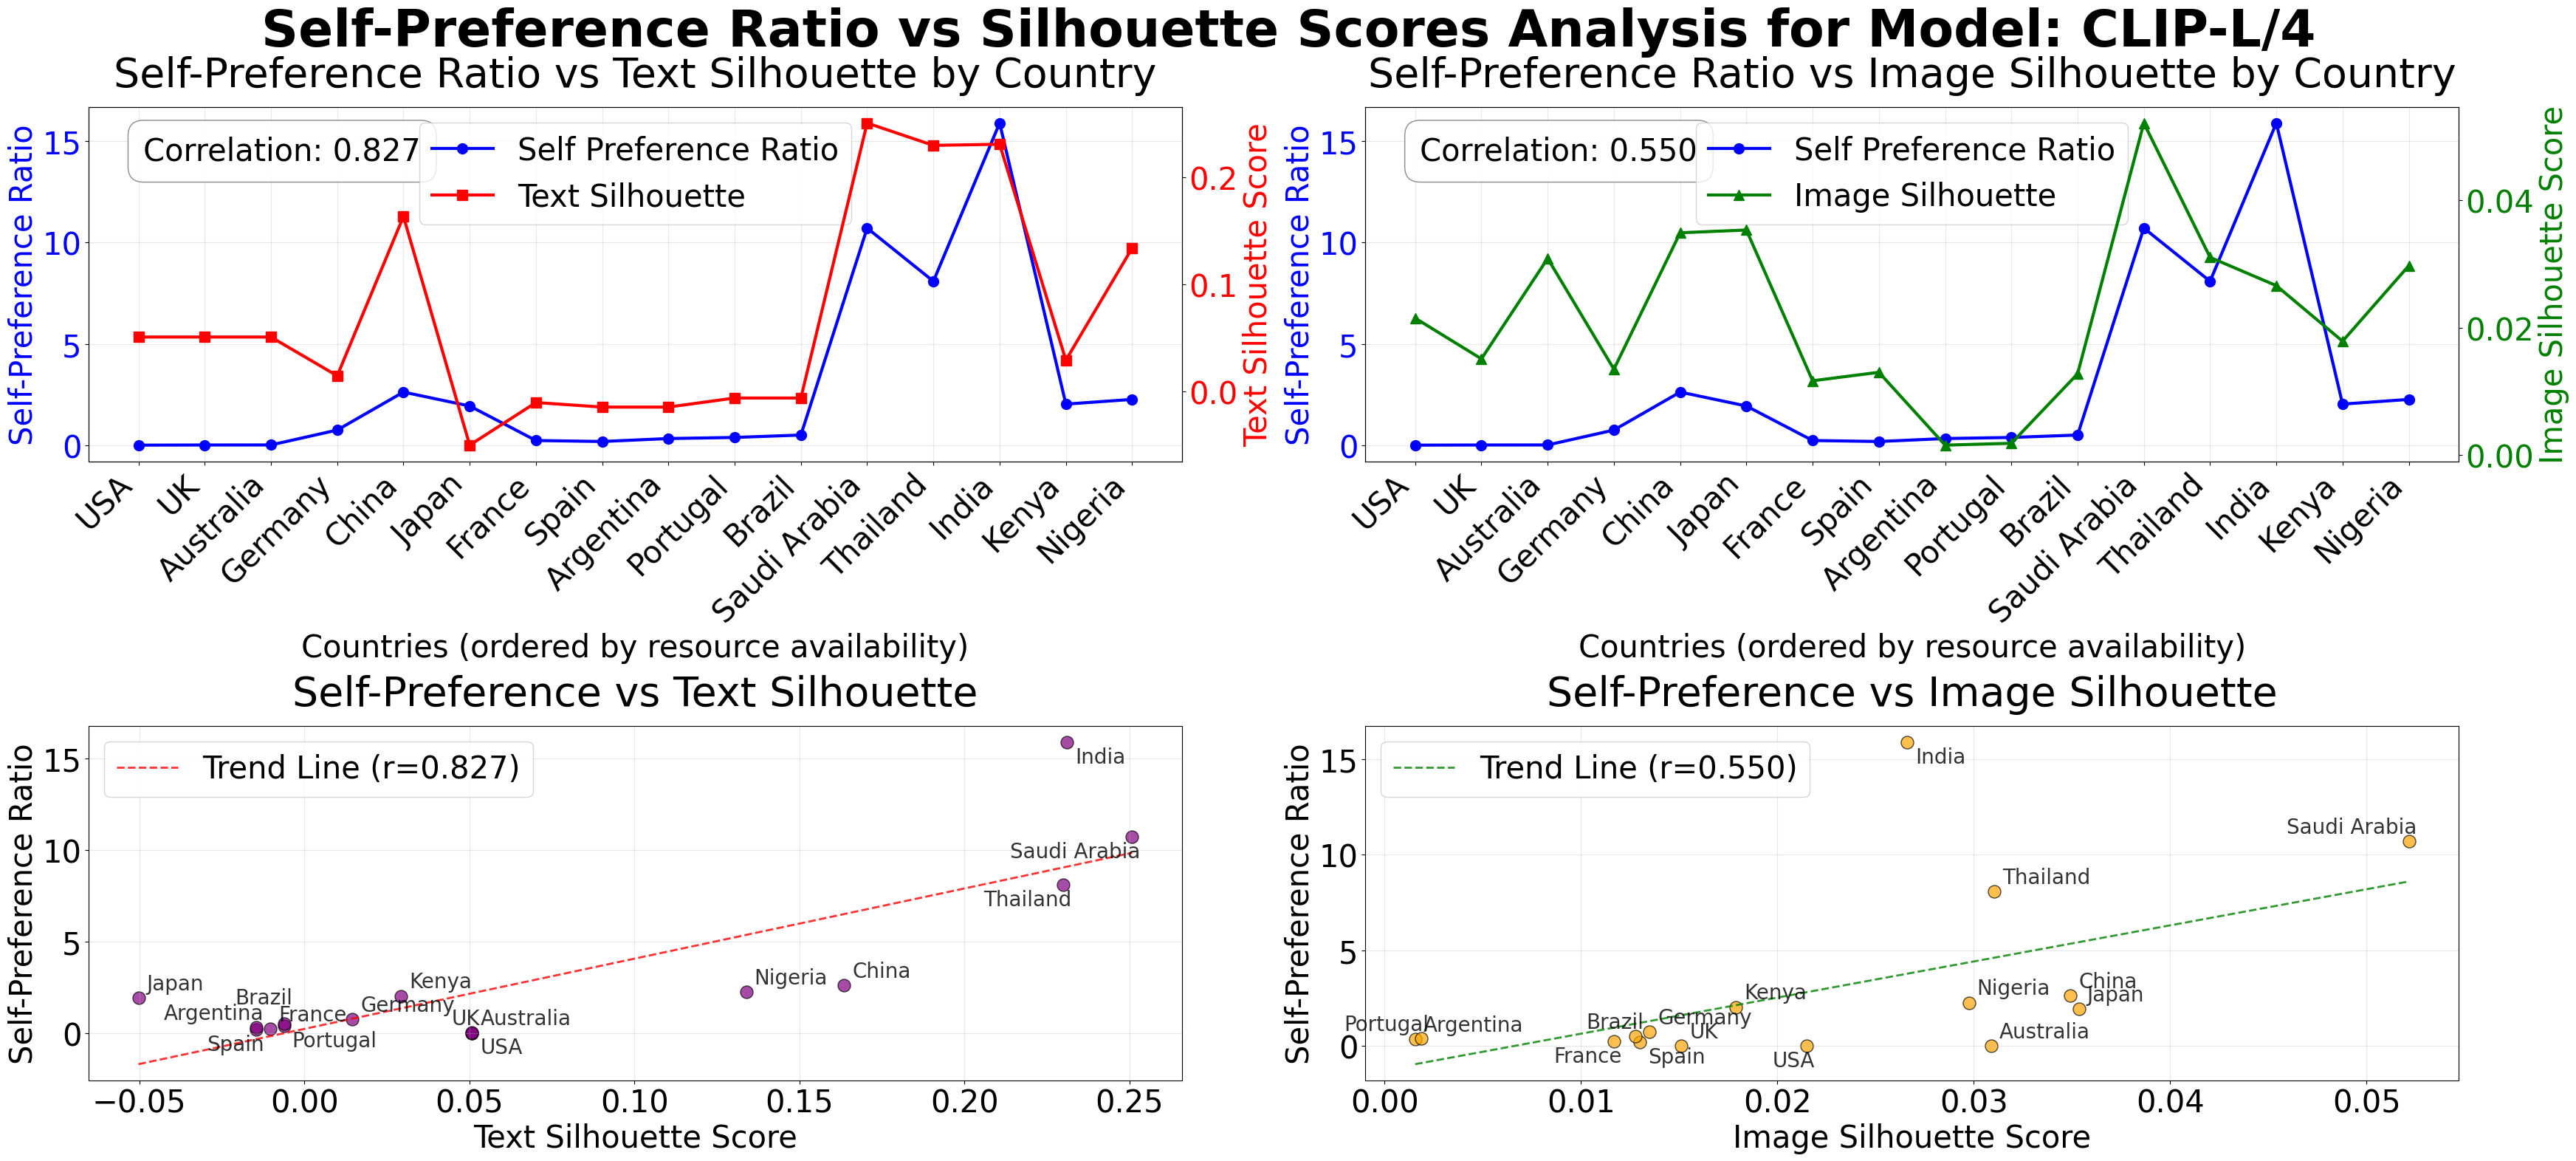


Summary for model: clip-vit-large-patch14
Correlation between Self-Preference Ratio and Text Silhouette: 0.8270
Correlation between Self-Preference Ratio and Image Silhouette: 0.5504
Countries analyzed: 16
Self-Preference Ratio range: 0.014 - 15.884
Text Silhouette Score range: -0.050 - 0.251
Image Silhouette Score range: 0.002 - 0.052


In [197]:
# Example usage of the new plotting function
comparison_data = plot_self_preference_vs_silhouette_scores(
    MODEL_NAME,
    country_df,
    translated_concept_country_silhouette_scores,
    image_country_silhouette_scores,
    country_to_language
)

In [ ]:
analyze_self_preference_and_silhouette_correlation(
    MODEL_NAME,
    country_df,
    translated_concept_country_silhouette_scores,
    image_country_silhouette_scores,
    country_to_language
)

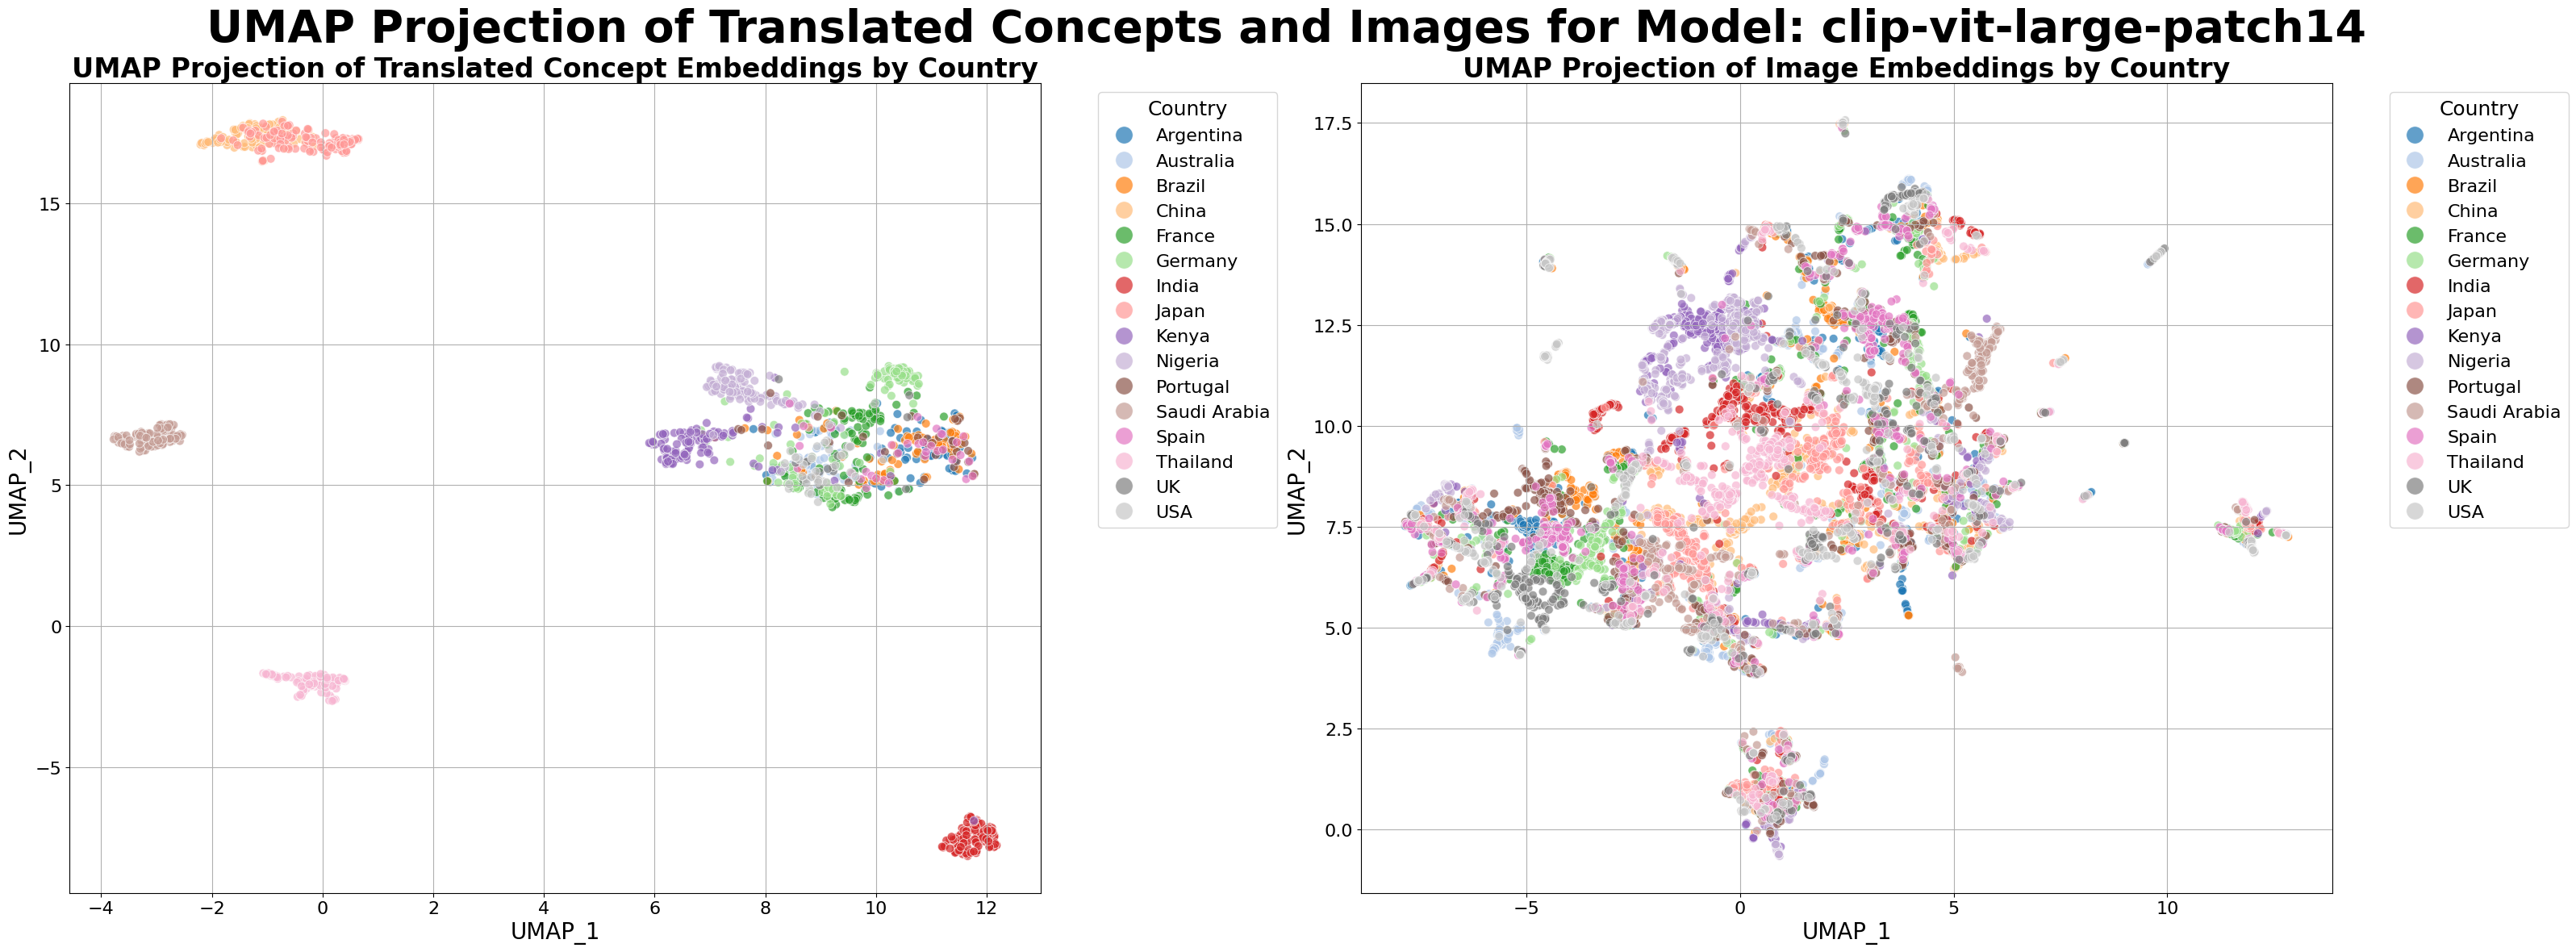

In [ ]:
# Plot UMAP embeddings for translated concepts and images
plot_umap_embeddings(
    MODEL_NAME,
    umap_translated_concept_embeddings,
    umap_image_embeddings,
    translated_concept_language_labels,  # Changed to use language labels for consistency
    translated_concept_labels,
    image_country_labels,
    dataset['concept']  # image_concept_labels
)